In [133]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as pyascii
import pandas as pd
import sys
import astropy.io.fits as fits
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from functions import *

#location of the calibrated spectrum of the companion
loc = '/Users/rasen/Documents/PostPhD/hip_77911_LSS/speckle_subtract/spec_comp_cal.dat'
indiv_obj = '2MASS J0428+1839' #change to name of individual object to fit and plot if desired
only_young = 0 #change to 1 if only a comparison to young objects is desired

In [134]:
#Read names, spectral types and URLS to download fits files
df = pd.read_csv('Montreal_Spectral_Library.csv', sep = ";")
n_mont = df['Name']
y_mont = df['Young?']
st_mont = df['SpT']
url_mont = df['URL']

In [135]:
#Clean the spectral type and gravity index 
#I've already removed from the list binaries and those with an uncertain ST
st_mont = [i.lstrip('< ') for i in st_mont] #assume latest st
st_clean = [i.split(' ') for i in st_mont] # [st, grav, smthg else]
st = [i[0].replace(':', '') for i in st_clean]
grav = [i[1] if len(i) > 1 else 'old' for i in st_clean]
grav_str = ['beta', 'gamma', 'delta']
grav = [i if i in grav_str else '--' for i in grav]


In [136]:
#read the calibrated spectrum of the companion
dummy = pyascii.read(loc, data_start =2)
names=dummy.colnames
spec_wvl = np.array(dummy[names[0]])
spec_flx = np.array(dummy[names[1]])/1e3 #W/m2/micron 
spec_eflx = np.array(dummy[names[2]])/1e3

#I shorten a bit our SPHERE spectrum to match it to the montreal bandpasses
spec_flx = np.array([spec_flx[i] for i in np.arange(len(spec_wvl)) if 0.98 < spec_wvl[i] < 1.775  ])
spec_eflx = np.array([spec_eflx[i] for i in np.arange(len(spec_wvl)) if 0.98<spec_wvl[i] < 1.775 ])
spec_wvl = np.array([spec_wvl[i] for i in np.arange(len(spec_wvl)) if 0.98<spec_wvl[i] < 1.775 ])


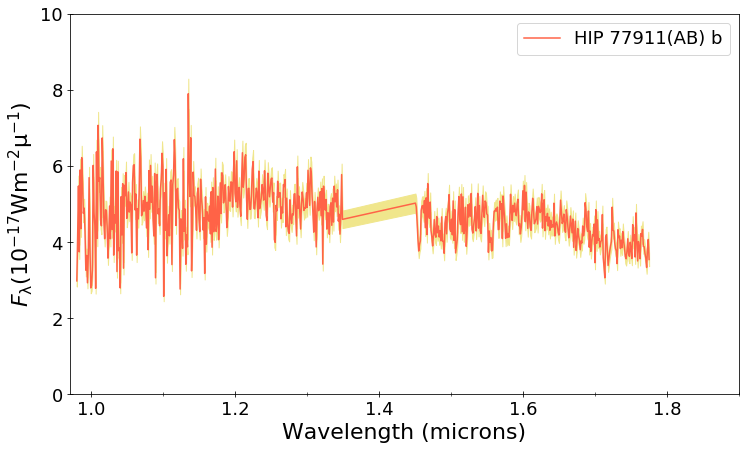

In [137]:
#Plot the calibrated spectrum of the companion
fig, ax = plt.subplots(figsize = (12, 7))
plt.xlim(0.97,1.8)
plt.ylim(0, 10)
ax.set_xlabel(r"Wavelength (microns)", fontsize=22)
ax.set_ylabel(r"$F\rm_{\lambda} (10^{-17}Wm^{-2}\mu^{-1})$", fontsize=22)
ax.tick_params(direction='inout', length=6, labelsize=18, axis='both', which='major')
ax.set_xticks([1.1,1.3,  1.5, 1.7, 1.9], minor=True)
ax.tick_params(direction='inout', length=4, labelsize=18, axis='x', which='minor')

plt.plot(spec_wvl,  spec_flx*1e17, 'tomato', label = 'HIP 77911(AB) b')
plt.fill_between(spec_wvl, (spec_flx - spec_eflx ) *1e17, (spec_flx + spec_eflx ) *1e17, alpha = 1, color = 'khaki')
plt.legend(fontsize=18)
plt.show()

In [138]:
#Loop through montreal objects and fit to the spectrum of the companion
name_ind=-1
Results_chisq = dict()

for name in n_mont: 
    name_ind+=1

    if indiv_obj != 0:
        if name != indiv_obj: continue
    
    if only_young == 1 and y_mont[name_ind] != 'Y': continue #if keyword = 'Y', read only the young ones
    
    #Read the montreal object
    mont = fits.open(url_mont[name_ind], mode='readonly')[0].data
    mont_wvl = mont[0] ; mont_flx = mont[1]; mont_eflx = mont[2]
    ST_mont = st[name_ind] ; thisgrav = grav[name_ind]
    #print(name)
    #print(ST_mont)

    
    #Take only the part we're interested in
    mont_flx = mont_flx[np.logical_and(mont_wvl<1.85,mont_wvl>0.9)]
    mont_eflx = mont_eflx[np.logical_and(mont_wvl<1.85,mont_wvl>0.9)]
    mont_wvl = mont_wvl[np.logical_and(mont_wvl<1.85,mont_wvl>0.9)]
    
    good = np.logical_and(mont_flx > 0.,np.isfinite(mont_flx) == True)
    mont_flx = mont_flx[good]; mont_eflx = mont_eflx[good]; mont_wvl_good = mont_wvl[good]

    if mont_wvl_good[-1] < 1.7 or mont_wvl_good[0] > 1.16: continue

    #wavelenght not increasing monotonically
    if (np.any(mont_wvl_good[1:] <= mont_wvl_good[:-1])) ==True: continue

    #I only take those with good precision
    if np.median(mont_eflx)/np.median(mont_flx) > 0.05: continue 

    #Convert the empirical spectrum to SPHERE'S LSS resolution
    mont_sph_f,mont_sph_ef = apply_res_sphere_lss(mont_wvl_good,mont_flx, mont_eflx, spec_wvl)
    #plt.figure()
    #plt.plot(spec_wvl, mont_sph_f)
    #plt.show()
    #If there's a bad (mainly because the given model has a lower resolution than SPHERE)
    nansandinf = [ i for i in np.arange(np.size(mont_sph_f)) if np.isfinite(mont_sph_f[i]) == False or mont_sph_f[i]<=0]
    if len(nansandinf)!=0: continue
    
    #Get Gval and C factor
    chi_sq, C_fac = G_value(spec_flx,spec_eflx, mont_sph_f)
    
    Results_chisq[name] = ST_mont, thisgrav, chi_sq

        
        
        

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


In [139]:
res = Results_chisq
info=list(res.values())
ST=[] ; chi_sq = []; grav_list = []

for i in info:
    #if '.2' in i[0] or '.7' in i[0]: ST=i[0][:2]
    #else: ST=i[0]
    ST.append(i[0])
    grav_list.append(i[1])
    chi_sq.append(i[2])

mmm = np.where(chi_sq==min(chi_sq))
minimum = mmm[0][0]
titles = list(res.keys())
best_obj = titles[minimum]
best_chi_sq = chi_sq[minimum]
best_ST = ST[minimum]
best_grav = grav_list[minimum]
print(best_ST)
print(best_obj)
print(best_chi_sq)
print(best_grav)

M3
2MASS J0428+1839
5804.65714713
--


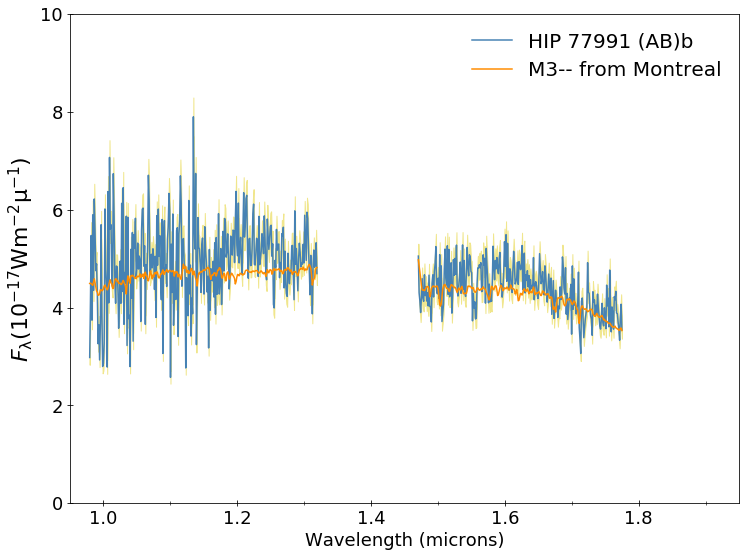

In [140]:
#Plot the individual (best?) object 
if indiv_obj !=0:
    #plot companion spectrum and empirical
    fig, ax = plt.subplots(figsize = (12, 9))
    plt.xlim(0.95,1.95)
    plt.ylim(0, 10)
    ax.set_xlabel(r"Wavelength (microns)", fontsize=18)
    ax.set_ylabel(r"$F\rm_{\lambda} (10^{-17}Wm^{-2}\mu^{-1}$)", fontsize=22)
    ax.tick_params(direction='inout', length=6, labelsize=18, axis='both', which='major')
    ax.set_xticks([1.1,1.3,  1.5, 1.7, 1.9], minor=True)
    ax.tick_params(direction='inout', length=4, labelsize=18, axis='x', which='minor')


    #get rid of region affected by tellurics
    f_spec_flx = [spec_flx[i] for i in np.arange(len(spec_flx)) if spec_wvl[i]<1.32]
    f_spec_eflx = [spec_eflx[i] for i in np.arange(len(spec_wvl)) if spec_wvl[i]<1.32]
    f_mont_sph_f = [mont_sph_f[i] for i in np.arange(len(spec_wvl)) if spec_wvl[i]<1.32]
    f_spec_wvl = [spec_wvl[i] for i in np.arange(len(spec_wvl)) if spec_wvl[i]<1.32]

    s_spec_flx = [spec_flx[i] for i in np.arange(len(spec_flx)) if spec_wvl[i]>1.47]
    s_spec_eflx = [spec_eflx[i] for i in np.arange(len(spec_wvl)) if spec_wvl[i]>1.47]
    s_mont_sph_f = [mont_sph_f[i] for i in np.arange(len(spec_wvl)) if spec_wvl[i]>1.47]
    s_spec_wvl = [spec_wvl[i] for i in np.arange(len(spec_wvl)) if spec_wvl[i]>1.47]


    plt.plot(f_spec_wvl, np.array(f_spec_flx)*1e17, 'steelblue',label = 'HIP 77991 (AB)b')
    plt.plot(f_spec_wvl, np.array(f_mont_sph_f)*C_fac*1e17, 'darkorange',label = ST[0] + thisgrav+' from Montreal')
    plt.fill_between(f_spec_wvl, (np.array(f_spec_flx) - np.array(f_spec_eflx) ) *1e17, \
                    (np.array(f_spec_flx) + np.array(f_spec_eflx)) *1e17, alpha = 1, color = 'khaki')

    plt.plot(s_spec_wvl, np.array(s_spec_flx)*1e17, 'steelblue')
    plt.plot(s_spec_wvl, np.array(s_mont_sph_f)*C_fac*1e17, 'darkorange')
    plt.fill_between(s_spec_wvl, (np.array(s_spec_flx) - np.array(s_spec_eflx) ) *1e17, \
                    (np.array(s_spec_flx) + np.array(s_spec_eflx)) *1e17, alpha = 1, color = 'khaki')


    plt.legend(frameon=False, fontsize = 20)
    plt.savefig('Bestfit_Montreal.eps', format = 'eps')
    plt.show()
